# Crime and Parks

For our final project we wanted to know whether areas with more parks had less crime than areas with fewer or no parks.

In order to investigate this question we decided to look at crime and park data from 5 major cities: New York City, Chicago, Philadelphia, Boston, and San Francisco. Because we are looking at a geographic connection, we decided to look at only one year at a time. We initially looked only at the year 2016.

For data we will use:

* Park or "Open Space" data or shapefiles from:
  * New York City: https://data.cityofnewyork.us/Recreation/Open-Space-Parks-/g84h-jbjm
  * Chicago: https://dev.socrata.com/foundry/data.cityofchicago.org/ejsh-fztr
  * Philadelphia: https://www.opendataphilly.org/dataset/parks-and-recreation-assets
  * Boston: https://data.boston.gov/dataset/open-space
  * San Francisco: https://data.sfgov.org/Culture-and-Recreation/Park-and-Open-Space-Map/4udc-s3pr


* Common geographical areas from:
  * New York City: https://dev.socrata.com/foundry/data.cityofnewyork.us/kmub-vria
  * Chicago: https://dev.socrata.com/foundry/data.cityofchicago.org/igwz-8jzy
  * Philadelphia: https://www.opendataphilly.org/dataset/police-districts
  *               https://services.arcgis.com/fLeGjb7u4uXqeF9q/arcgis/rest/services/Boundaries_District/FeatureServer/0/query?outFields=*&where=1%3D1
  * Boston: http://bostonopendata-boston.opendata.arcgis.com/datasets/9a3a8c427add450eaf45a470245680fc_5.zip (Shape file, not a landing page)
  * San Francisco: https://dev.socrata.com/foundry/data.sfgov.org/q52f-skbd
  

* Crime APIs and data from:
  * New York City: https://dev.socrata.com/foundry/data.cityofnewyork.us/9s4h-37hy
  * Chicago: https://dev.socrata.com/foundry/data.cityofchicago.org/6zsd-86xi
  * Philadelphia: https://cityofphiladelphia.github.io/carto-api-explorer/#incidents_part1_part2
  * Boston: https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system
  * San Francisco: https://dev.socrata.com/foundry/data.sfgov.org/cuks-n6tp

Boston does not have an API interface, so we will instead download the csv directly. Luckily Boston switched from an old system to a new system, so the csv file we are interested in only has data from August 2015 to present, which will make it less arduous to download and work with.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import shape


import requests, json

import pandas as pd
import seaborn as sns
sns.set_style({"axes.grid": "False"}, {'axes.axisbelow': "False"})
sns.set_style({"axes.linewidth": 0})

import pytz
import datetime

from urllib.parse import quote

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.mixed_linear_model as sm_mlm

from time import sleep

C:\cygwin64\home\mjcor\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Chicago

We will acquire the data for crime in Chicago similarly to how we did in class for the Weather and Crime example.

In [190]:
soql = "https://data.cityofchicago.org/resource/6zsd-86xi.json?$query="
soql += quote("SELECT id, community_area, primary_type ")
soql += quote("WHERE year == 2016 ")
soql += quote("LIMIT 300000")

resp = requests.get(soql).json()
chicago_crime = pd.DataFrame(resp)
chi_CA_count = chicago_crime.groupby("community_area").count()

In [191]:
soql = "https://data.cityofchicago.org/resource/igwz-8jzy.json?$query="
soql += quote("SELECT area_numbe as Number, community, the_geom ")
soql += quote("LIMIT 300000")

resp = requests.get(soql).json()

Because the data is downloaded as a json object, and thus parsed as a dictionary, we must convert it into geopandas data frame. 

In [192]:
data = resp
for d in data:
    d['the_geom'] = shape(d['the_geom'])

chicago_comm_areas = gpd.GeoDataFrame(data).set_geometry('the_geom')
chicago_comm_areas.crs = {'init' :'epsg:4269'}
chicago_comm_areas.head()

,Number,community,the_geom
0,35,DOUGLAS,(POLYGON ((-87.60914087617894 41.8446925026539...
1,36,OAKLAND,(POLYGON ((-87.59215283879394 41.8169293462668...
2,37,FULLER PARK,(POLYGON ((-87.62879823733725 41.8018930336891...
3,38,GRAND BOULEVARD,(POLYGON ((-87.6067081256125 41.81681377057218...
4,39,KENWOOD,(POLYGON ((-87.59215283879394 41.8169293462668...


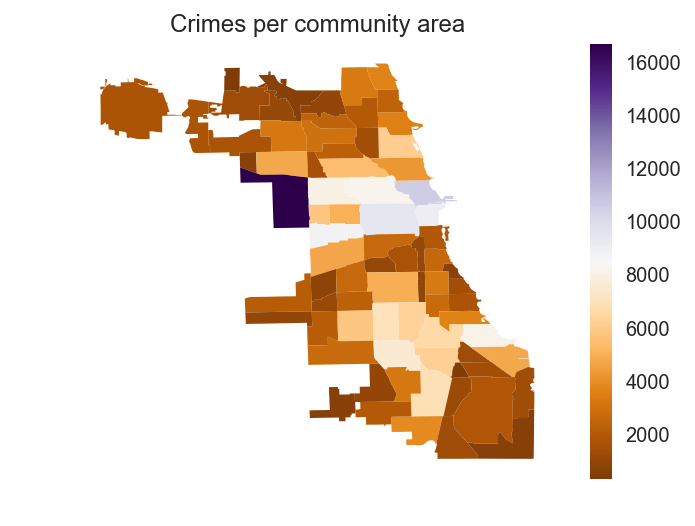

In [193]:
chi_CA_count = chi_CA_count.reset_index()
chicago_comm_areas = chicago_comm_areas.merge(chi_CA_count, left_on = 'Number', right_on = 'community_area')

In [ ]:
SFMap = SF_merge.plot(column = 'incidntnum', scheme = "equal_interval", k = 11, cmap = 'plasma', legend=True,
             linewidth = 2, edgecolor = "black", figsize = (9, 5))

SFMap.set_title("Crime per police district in San Francisco (2016)", fontsize = 20)
SFMap.set_axis_off()
SFMap.get_legend().set_bbox_to_anchor((1.35, .65))
SFMap.get_legend().get_frame().set_linewidth(0)

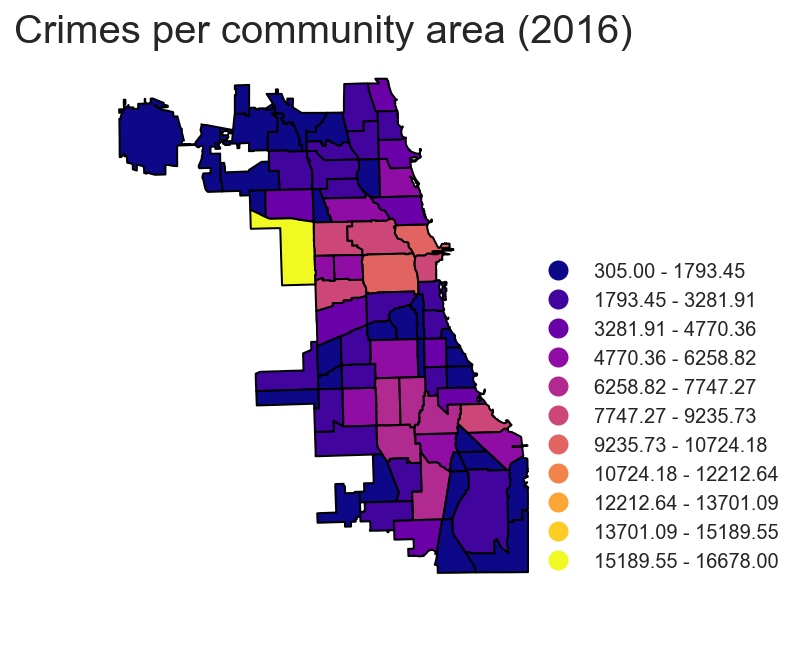

In [357]:
CAMap = chicago_comm_areas.to_crs(epsg = 3528).plot(column = 'id', scheme = 'equal_interval', k = 11, cmap = 'plasma', legend=True,
                               linewidth = 1, edgecolor = 'black', figsize = (9,5))
CAMap.set_title("Crimes per community area (2016)", fontsize = 20)
CAMap.set_axis_off()
CAMap.get_legend().set_bbox_to_anchor((1.55, .65))
CAMap.get_legend().get_frame().set_linewidth(0)

In [194]:
chi_CA_count.set_index('community_area', inplace = True)

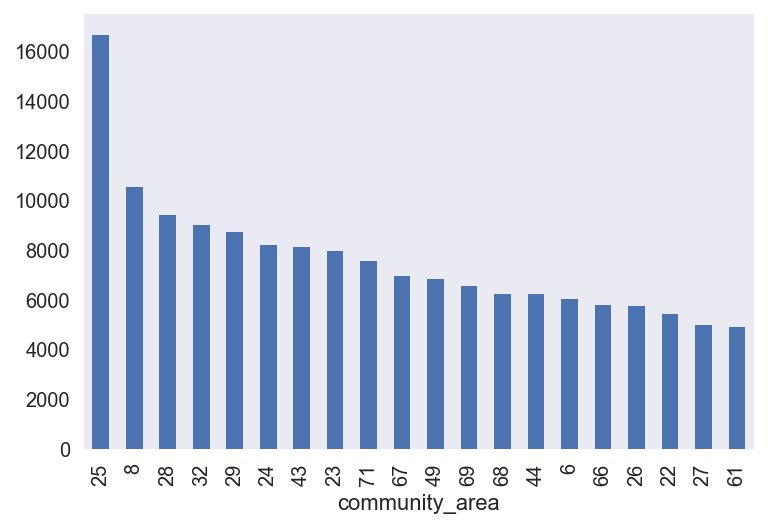

In [195]:
chi_CA_count.sort_values('id', ascending = False)['id'].head(20).plot.bar()

So community area 25 is by far the highest total amount of crime in 2016.

In [196]:
CAPop = pd.read_csv("CAPop.csv", dtype={'Community Area': str})

In [197]:
chicago_comm_areas = chicago_comm_areas.merge(CAPop, left_on = "community_area", right_on = "Community Area")

In [198]:
chicago_comm_areas.head()

,Number,community,the_geom,community_area,id,primary_type,Community Area,Population
0,35,DOUGLAS,(POLYGON ((-87.60914087617894 41.8446925026539...,35,2597,2597,35,18238
1,36,OAKLAND,(POLYGON ((-87.59215283879394 41.8169293462668...,36,698,698,36,5918
2,37,FULLER PARK,(POLYGON ((-87.62879823733725 41.8018930336891...,37,925,925,37,2876
3,38,GRAND BOULEVARD,(POLYGON ((-87.6067081256125 41.81681377057218...,38,3284,3284,38,21929
4,39,KENWOOD,(POLYGON ((-87.59215283879394 41.8169293462668...,39,1405,1405,39,17841


In [199]:
chicago_comm_areas['Crimes per person'] = chicago_comm_areas['id']/chicago_comm_areas['Population']

In [200]:
chicago_comm_areas.head()

,Number,community,the_geom,community_area,id,primary_type,Community Area,Population,Crimes per person
0,35,DOUGLAS,(POLYGON ((-87.60914087617894 41.8446925026539...,35,2597,2597,35,18238,0.142395
1,36,OAKLAND,(POLYGON ((-87.59215283879394 41.8169293462668...,36,698,698,36,5918,0.117945
2,37,FULLER PARK,(POLYGON ((-87.62879823733725 41.8018930336891...,37,925,925,37,2876,0.321627
3,38,GRAND BOULEVARD,(POLYGON ((-87.6067081256125 41.81681377057218...,38,3284,3284,38,21929,0.149756
4,39,KENWOOD,(POLYGON ((-87.59215283879394 41.8169293462668...,39,1405,1405,39,17841,0.078751


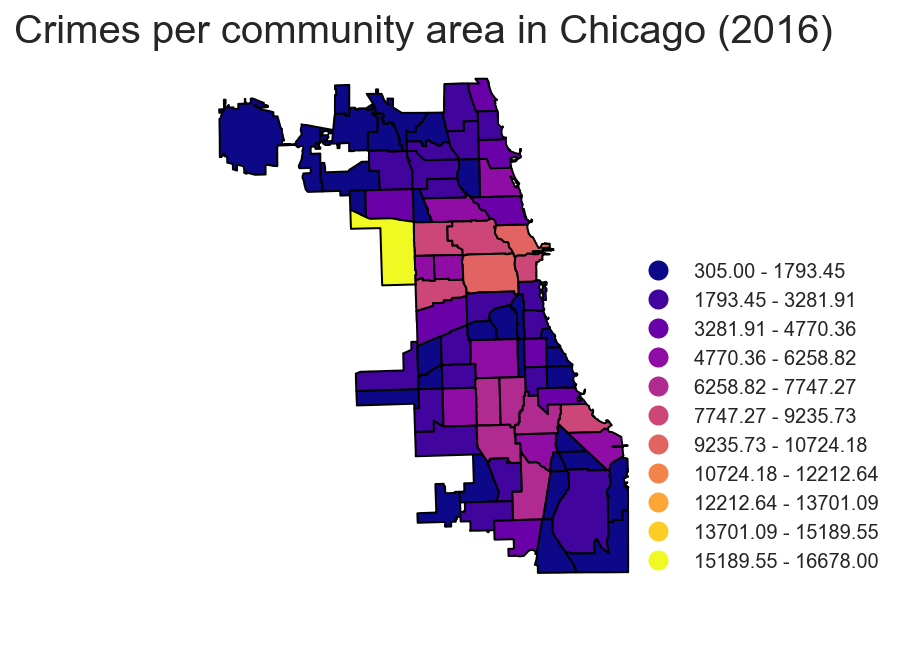

In [378]:
CAMap = chicago_comm_areas.to_crs(epsg = 3528).plot(column = 'id', scheme = 'equal_interval', k = 11, cmap = 'plasma', legend=True,
                               linewidth = 1, edgecolor = 'black', figsize = (9,5))
CAMap.set_title("Crimes per community area in Chicago (2016)", fontsize = 20)
CAMap.set_axis_off()
CAMap.get_legend().set_bbox_to_anchor((1.55, .65))
CAMap.get_legend().get_frame().set_linewidth(0)

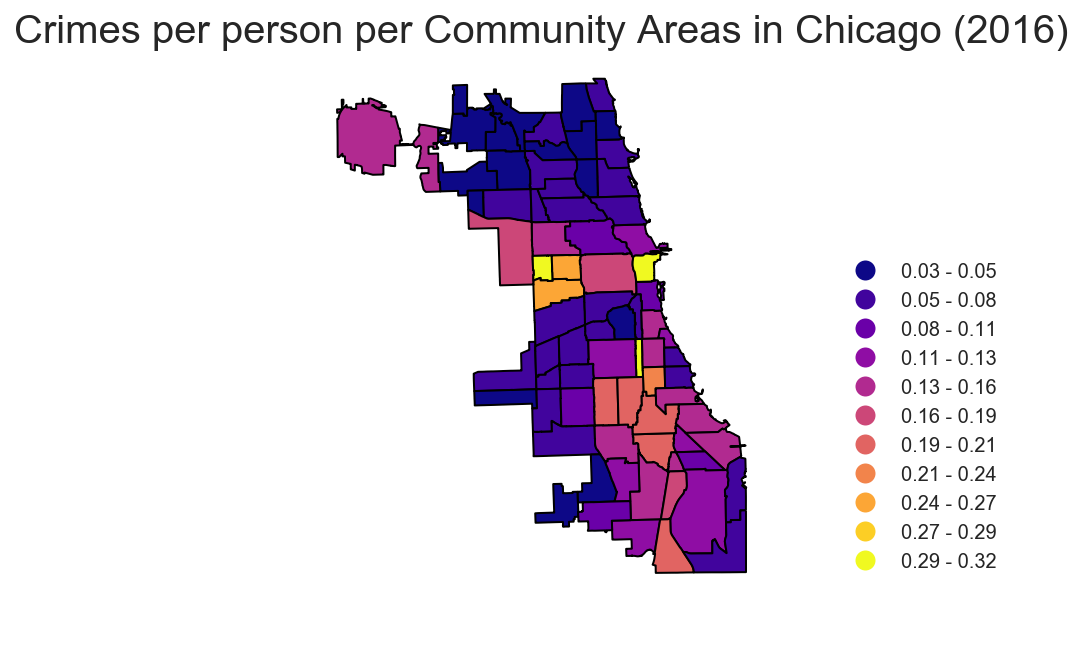

In [379]:
PerPerson = chicago_comm_areas.to_crs(epsg = 3528).plot(column = 'Crimes per person', scheme='equal_interval', k = 11, cmap = 'plasma', legend=True,
                                   linewidth = 1, edgecolor = 'black', figsize = (9,5))
PerPerson.set_title("Crimes per person per Community Areas in Chicago (2016)", fontsize = 20)
PerPerson.set_axis_off()

PerPerson.get_legend().set_bbox_to_anchor((1.55, .65))
PerPerson.get_legend().get_frame().set_linewidth(0)

The map looks slightly different now that we adjusted for population in the community areas.

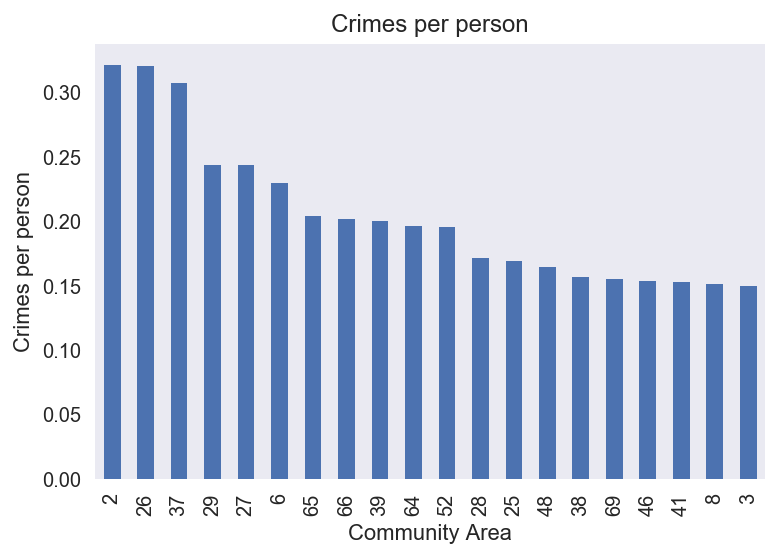

In [169]:
CPP = chicago_comm_areas[['Number','Crimes per person']].sort_values('Crimes per person', ascending = False).head(20).plot.bar()
CPP.set_title("Crimes per person")
CPP.set_xlabel("Community Area")
CPP.set_ylabel("Crimes per person")
CPP.legend_.remove()

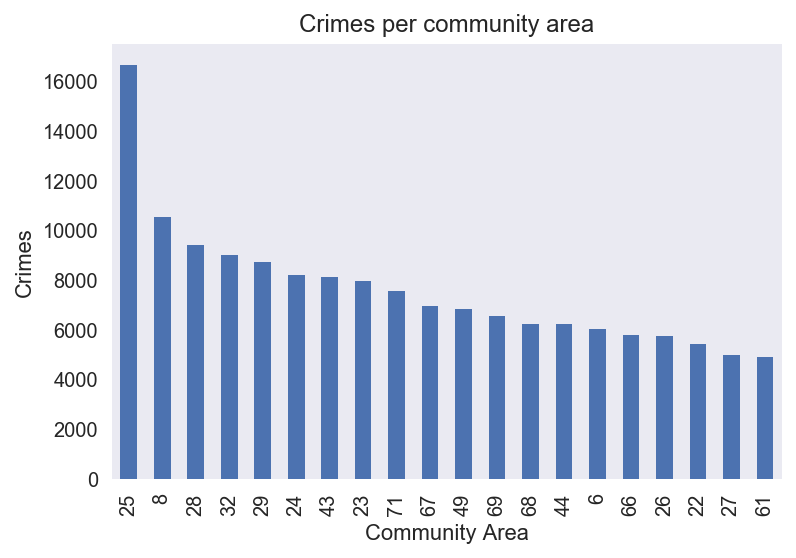

In [170]:
#chi_CA_count.set_index('community_area', inplace = True)
CCA = chi_CA_count.sort_values('id', ascending = False)['id'].head(20).plot.bar()
CCA.set_title("Crimes per community area")
CCA.set_xlabel("Community Area")
CCA.set_ylabel("Crimes")

In [171]:
soql = "https://data.cityofchicago.org/resource/ejsh-fztr.json?$query="
soql += quote("SELECT park_no, acres ")
soql += quote("LIMIT 300000")

resp = requests.get(soql).json()

In [172]:
parkacres = resp

In [173]:
soql = "https://data.cityofchicago.org/resource/eix4-gf83.json?$query="
soql += quote("SELECT park, park_no, the_geom, x_coord, y_coord ")
soql += quote("LIMIT 300000")

resp = requests.get(soql).json()

In [174]:
data = resp
for d in data:
    d['the_geom'] = shape(d['the_geom'])

parkshapes = gpd.GeoDataFrame(data).set_geometry('the_geom')
parkshapes.head()

,park,park_no,the_geom,x_coord,y_coord
0,HAMILTON (ALEXANDER),9,POINT (-87.63769762611605 41.76299921071406),-87.63769763,41.76299921
1,HAMILTON (ALEXANDER),9,POINT (-87.63792902987225 41.76281652333733),-87.63792903,41.76281652
2,HAMILTON (ALEXANDER),9,POINT (-87.63691359952921 41.76084938932824),-87.6369136,41.76084939
3,HAMILTON (ALEXANDER),9,POINT (-87.63832013450852 41.76200535544225),-87.63832013,41.76200536
4,HAMILTON (ALEXANDER),9,POINT (-87.63805916837423 41.7604738451063),-87.63805917,41.76047385


Might be able to use community areas to define polygons, then take the api to only draw parks where the points are within the polygon. Need to parse data from community area polygons and SoQL query.

# New York City

We repeat the process for New York City. NYC had 478804 offenses in 2016, so we place a limit on on SoQL call of 500000

In [100]:
soql = "https://data.cityofnewyork.us/resource/9s4h-37hy.json?$query="
soql += quote("SELECT cmplnt_num,  addr_pct_cd, ofns_desc ")
soql += quote("WHERE date_trunc_y(rpt_dt) = '2016-01-01T00:00:00.000' ")
soql += quote("LIMIT 500000")

resp = requests.get(soql).json()
NYC_crime = pd.DataFrame(resp)
NYC_pre_count = NYC_crime.groupby("addr_pct_cd").count()

In [101]:
NYC_pre_count.reset_index(inplace = True)

In [102]:
NYC_pre_count.sort_values('addr_pct_cd', inplace = True)

In [103]:
NYC_pre_count.set_index('addr_pct_cd')
NYC_pre_count.reset_index(inplace = True)
NYC_pre_count.drop('index', axis = 1, inplace = True)

In [104]:
soql = "https://data.cityofnewyork.us/resource/kmub-vria.json?$query="
soql += quote("SELECT precinct, the_geom ")
soql += quote("LIMIT 500")

resp = requests.get(soql).json()

In [115]:
data = resp
for d in data:
    d['the_geom'] = shape(d['the_geom'])

NYC_precincts = gpd.GeoDataFrame(data).set_geometry('the_geom')
NYC_precincts.crs = {'init' :'epsg:2260'}
NYC_precincts.head()

,precinct,the_geom
0,1,(POLYGON ((-74.0438776157395 40.69018767637665...
1,5,(POLYGON ((-73.98863862848766 40.7229337202636...
2,6,(POLYGON ((-73.99968392160721 40.7385522486597...
3,71,(POLYGON ((-73.92854313809303 40.6645732858473...
4,72,(POLYGON ((-73.99840899113158 40.6718687230323...


In [107]:
NYC_precincts["precinct"][0]
NYC_pre_count['addr_pct_cd'][0]

'1'

In [ ]:
NYC_precincts = NYC_precincts.merge(NYC_pre_count, left_on = 'precinct', right_on = 'addr_pct_cd')

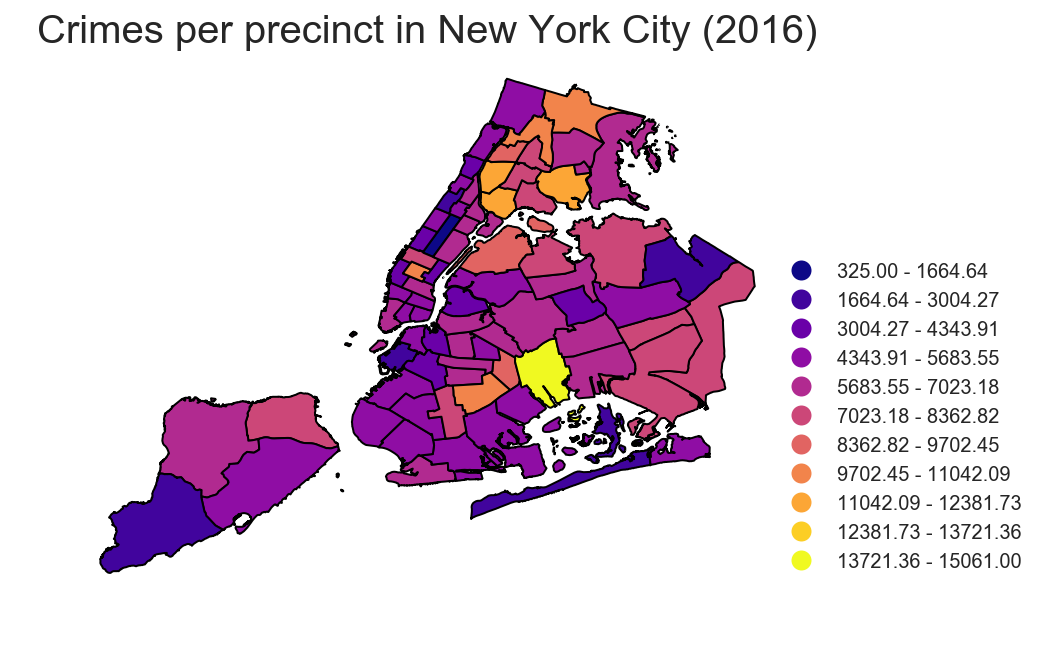

In [380]:
PreMap = NYC_precincts.to_crs(epsg = 2260).plot(column = 'cmplnt_num', scheme = 'equal_interval', k = 11, cmap = 'plasma', legend=True,
                           linewidth = 1, edgecolor = 'black', figsize = (9,5))
PreMap.set_title("Crimes per precinct in New York City (2016)", fontsize = 20)
PreMap.set_axis_off()

PreMap.get_legend().set_bbox_to_anchor((1.35, .65))
PreMap.get_legend().get_frame().set_linewidth(0)

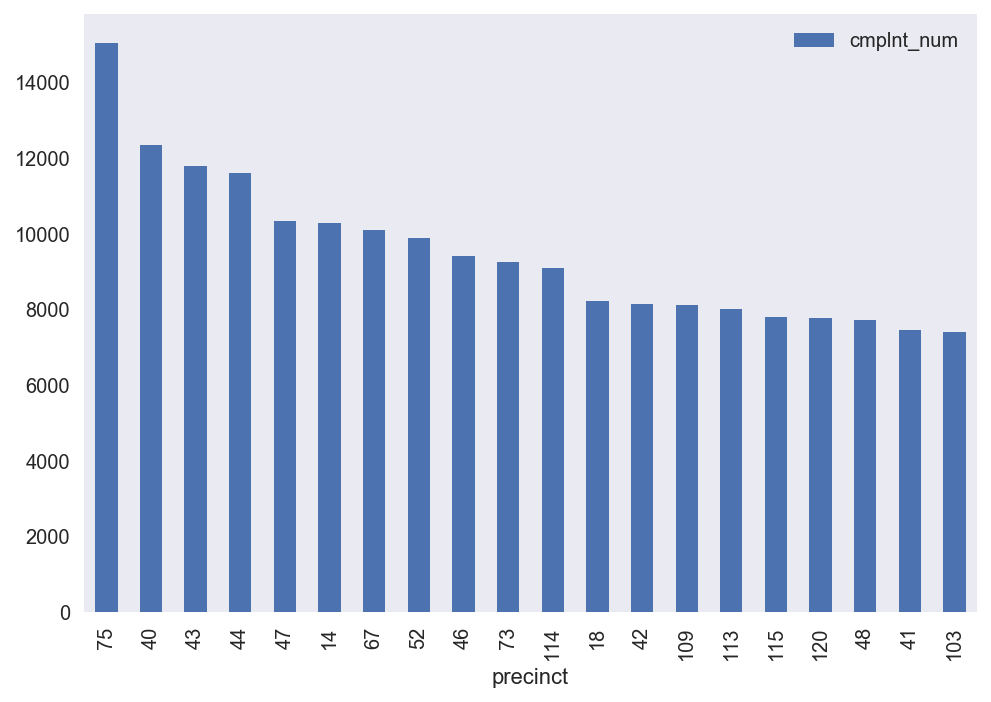

In [118]:
NYC_precincts[['precinct', 'cmplnt_num']].sort_values('cmplnt_num', ascending = False).head(20).plot.bar('precinct')

Will take some time, but can combine census block data with geographical files to find population per precinct.

# Boston

In [7]:
Boston_crime = pd.read_csv("Boston_crime.csv", usecols = ['OFFENSE_CODE', 'DISTRICT'])

In [8]:
Boston_crime.dropna(inplace = True)

In [9]:
Boston_crime = Boston_crime.groupby('DISTRICT').count()

In [10]:
Boston = gpd.read_file('./Police_Districts/Police_Districts.shp')

In [11]:
BostonMerge = Boston.merge(Boston_crime, left_on='DISTRICT', right_index=True)

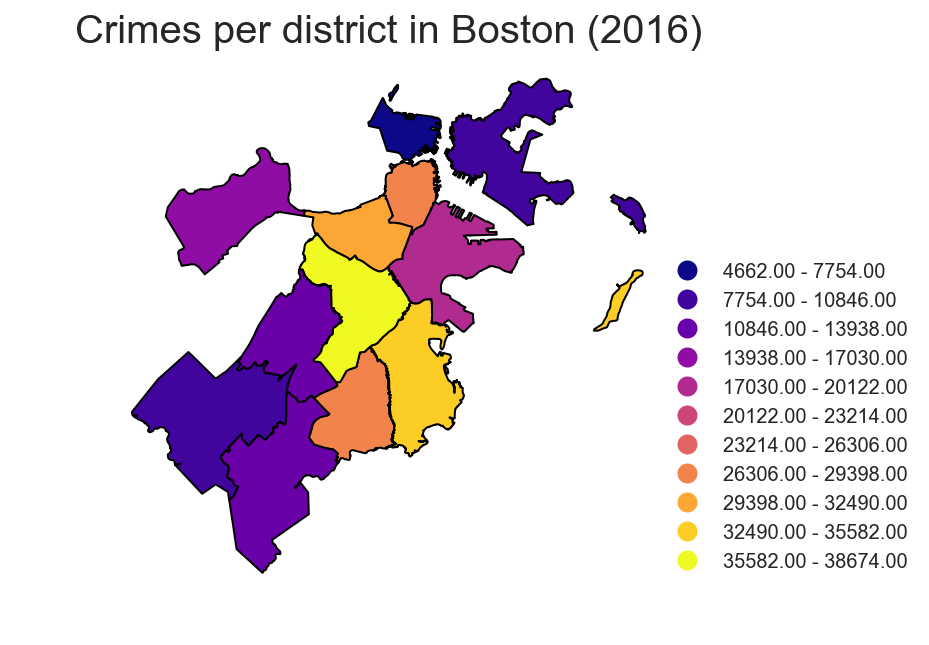

In [13]:
BoMap = BostonMerge.to_crs(epsg=2249).plot(column = 'OFFENSE_CODE', scheme = 'equal_interval', k = 11, cmap = 'plasma',
                                           legend=True, linewidth = 1, edgecolor = 'black', figsize = (9, 5))
BoMap.set_title("Crimes per district in Boston (2016)", fontsize = 20)
BoMap.set_axis_off()

BoMap.get_legend().set_bbox_to_anchor((1.45, .65))

# Philadelphia

In [22]:
sql = "https://phl.carto.com/api/v2/sql?q="
sql += quote("SELECT * ")
sql += quote('FROM incidents_part1_part2 ')
sql += quote("WHERE dispatch_date LIKE '2016-%' ")
sql += quote("LIMIT 200000")

resp = requests.get(sql).json()

In [23]:
resp.keys()

dict_keys(['rows', 'time', 'fields', 'total_rows'])

In [24]:
Philly = pd.DataFrame.from_dict(resp['rows'])

In [25]:
Philly_count = Philly.groupby('dc_dist').count()["psa"]

In [26]:
Philly_count = pd.DataFrame(Philly_count)

In [27]:
Philly_PD = gpd.read_file("./Boundaries_District/Boundaries_District.shp")

In [33]:
Philly_PD.head()

,OBJECTID,AREA,PERIMETER,DISTRICT_,DISTRICT_I,DIST_NUM,SUM_AREA,DIST_NUMC,LOCATION,PHONE,DIV_CODE,AREA_SQMI,geometry
0,321,None,81903.641825,1,None,1,None,01,24th St. & Wolf St.,686-3010,SPD,2.163501e+08,"POLYGON ((-75.1972400674602 39.9294369069777, ..."
1,322,None,63587.369399,2,None,2,None,02,Harbison Ave. & Levick St.,686-3020,NEPD,1.923461e+08,"POLYGON ((-75.0544438272491 40.0445408366907, ..."
2,323,None,55305.496227,3,None,3,None,03,11th St. & Wharton St.,686-3030,SPD,1.839049e+08,"POLYGON ((-75.1320532000924 39.8993215193001, ..."
3,324,None,71919.797243,5,None,5,None,05,Ridge Ave. & Cinnaminson St.,686-3050,NWPD,2.130442e+08,"POLYGON ((-75.20429961961899 40.034678202574, ..."
4,325,None,34655.320856,6,None,6,None,06,11th St. & Winter St.,686-3060,CPD,6.927927e+07,"POLYGON ((-75.1343658526971 39.9529396074571, ..."


In [34]:
Philly_merge = pd.merge(Philly_PD, Philly_count, left_on = "DIST_NUMC", right_index = True)

In [35]:
Philly_merge.head()

,OBJECTID,AREA,PERIMETER,DISTRICT_,DISTRICT_I,DIST_NUM,SUM_AREA,DIST_NUMC,LOCATION,PHONE,DIV_CODE,AREA_SQMI,geometry,psa
0,321,None,81903.641825,1,None,1,None,01,24th St. & Wolf St.,686-3010,SPD,2.163501e+08,"POLYGON ((-75.1972400674602 39.9294369069777, ...",3432
1,322,None,63587.369399,2,None,2,None,02,Harbison Ave. & Levick St.,686-3020,NEPD,1.923461e+08,"POLYGON ((-75.0544438272491 40.0445408366907, ...",8793
2,323,None,55305.496227,3,None,3,None,03,11th St. & Wharton St.,686-3030,SPD,1.839049e+08,"POLYGON ((-75.1320532000924 39.8993215193001, ...",7300
3,324,None,71919.797243,5,None,5,None,05,Ridge Ave. & Cinnaminson St.,686-3050,NWPD,2.130442e+08,"POLYGON ((-75.20429961961899 40.034678202574, ...",2392
4,325,None,34655.320856,6,None,6,None,06,11th St. & Winter St.,686-3060,CPD,6.927927e+07,"POLYGON ((-75.1343658526971 39.9529396074571, ...",7773


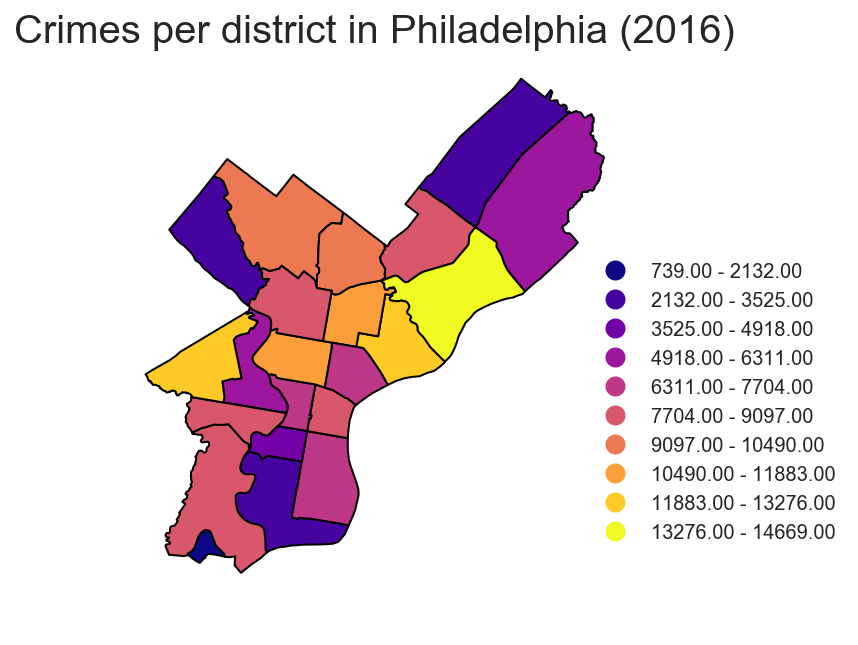

In [36]:
PhillyMap = Philly_merge.to_crs(epsg=2824).plot(column = 'psa', scheme = 'equal_interval', k = 10, cmap = 'plasma',
                                           legend=True, linewidth = 1, edgecolor = 'black', figsize = (9, 5))
PhillyMap.set_title("Crimes per district in Philadelphia (2016)", fontsize = 20)
PhillyMap.set_axis_off()

PhillyMap.get_legend().set_bbox_to_anchor((1.45, .65))

# San Francisco

In [278]:
soql = "https://data.sfgov.org/resource/cuks-n6tp.json?$query="
soql += quote("SELECT COUNT(*),  ")
soql += quote("WHERE date_trunc_y(date) = '2016-01-01T00:00:00.000' ")
soql += quote("LIMIT 300000")

resp = requests.get(soql).json()
SF_crime = pd.DataFrame(resp)
SF_crime_count = SF_crime.groupby('pddistrict').count()

In [282]:
SF_crime_count = SF_crime.groupby('pddistrict').count()['incidntnum']

In [295]:
SF_crime_count = pd.DataFrame(SF_crime_count)

In [286]:
soql = "https://data.sfgov.org/resource/q52f-skbd.json?$query="
soql += quote("SELECT district, the_geom ")
soql += quote("LIMIT 500")

resp = requests.get(soql).json()

In [287]:
data = resp
for d in data:
    d['the_geom'] = shape(d['the_geom'])

SF_precincts = gpd.GeoDataFrame(data).set_geometry('the_geom')
SF_precincts.head()

,district,the_geom
0,SOUTHERN,(POLYGON ((-122.3918613881226 37.7942468097054...
1,BAYVIEW,(POLYGON ((-122.3809828136006 37.7648002201901...
2,MISSION,"(POLYGON ((-122.4095391743523 37.769317718404,..."
3,NORTHERN,(POLYGON ((-122.4337921715291 37.8079301070697...
4,TENDERLOIN,(POLYGON ((-122.4021713308171 37.7862601311238...


In [289]:
SF_crime.head()

,address,category,date,dayofweek,descript,incidntnum,location,pddistrict,pdid,resolution,time,x,y
0,500 Block of 38TH AV,NON-CRIMINAL,2016-03-16T00:00:00.000,Wednesday,CASE CLOSURE,170878503,"{'type': 'Point', 'coordinates': [-122.4986606...",RICHMOND,17087850375030,UNFOUNDED,15:00,-122.49866066033435,37.77847148817511
1,15TH ST / GUERRERO ST,SUSPICIOUS OCC,2016-05-30T00:00:00.000,Monday,INVESTIGATIVE DETENTION,160441499,"{'type': 'Point', 'coordinates': [-122.4242605...",MISSION,16044149964085,NONE,11:36,-122.42426056137934,37.7664064445087
2,900 Block of MISSION ST,WARRANTS,2016-10-12T00:00:00.000,Wednesday,WARRANT ARREST,160833545,"{'type': 'Point', 'coordinates': [-122.4068921...",SOUTHERN,16083354563010,"ARREST, BOOKED",23:00,-122.40689217002914,37.782483165814085
3,1000 Block of KEY AV,WARRANTS,2016-12-06T00:00:00.000,Tuesday,WARRANT ARREST,161000735,"{'type': 'Point', 'coordinates': [-122.3973282...",BAYVIEW,16100073563010,NONE,21:00,-122.39732823894188,37.7196121077812
4,200 Block of BUSH ST,FORGERY/COUNTERFEITING,2016-12-05T00:00:00.000,Monday,"CHECKS OR LEGAL INSTRUMENTS, UTTERING FORGED",170892296,"{'type': 'Point', 'coordinates': [-122.4021896...",CENTRAL,17089229609016,NONE,00:01,-122.40218963261235,37.79093729459998


In [299]:
SF_merge = pd.merge(SF_precincts, SF_crime_count, left_on = 'district', right_index = True)

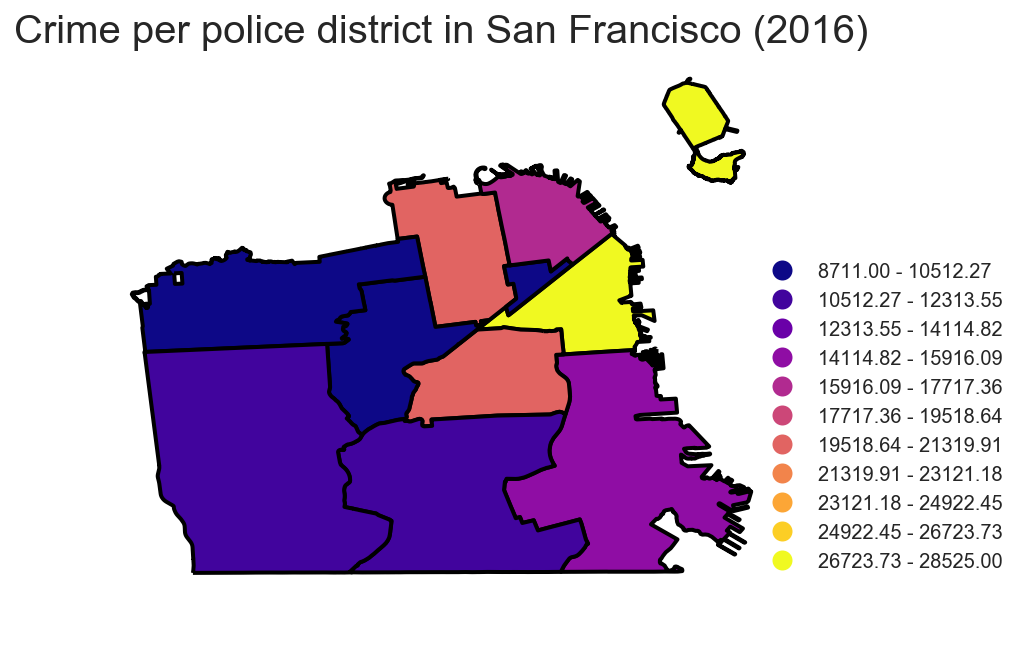

In [339]:
SFMap = SF_merge.plot(column = 'incidntnum', scheme = "equal_interval", k = 11, cmap = 'plasma', legend=True,
             linewidth = 2, edgecolor = "black", figsize = (9, 5))

SFMap.set_title("Crime per police district in San Francisco (2016)", fontsize = 20)
SFMap.set_axis_off()
SFMap.get_legend().set_bbox_to_anchor((1.35, .65))
SFMap.get_legend().get_frame().set_linewidth(0)

In [301]:
SF_merge.head()

,district,the_geom,incidntnum
0,SOUTHERN,(POLYGON ((-122.3918613881226 37.7942468097054...,28525
1,BAYVIEW,(POLYGON ((-122.3809828136006 37.7648002201901...,14338
2,MISSION,"(POLYGON ((-122.4095391743523 37.769317718404,...",19538
3,NORTHERN,(POLYGON ((-122.4337921715291 37.8079301070697...,20128
4,TENDERLOIN,(POLYGON ((-122.4021713308171 37.7862601311238...,9952
